In [1]:
from bipedplant_roughness import BipedEnv
import os
import numpy as np
from stable_baselines3 import PPO, SAC
import time
import animatebiped
import gait_generator

print('All packages are installed and working.')

All packages are installed and working.


In [2]:
desired_speed = 2.0
model = PPO.load("weights/model_checkpoint_58PPOtaga_adapreward.zip")

/home/baran/biped_env/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
import matplotlib.pyplot as plt
env = BipedEnv(render_mode='animate')
obs, info = env.reset()  # Gym API
angle_array = np.empty((0,4))
for i in range(0, 50000):
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env.step(action)
    # states = obs[2:16]
    # angles = np.pi/2 - states[[4,10,7,13]]
    # angles[1] = angles[1] - angles[0]
    # angles[3] = angles[3] - angles[2]
    # angle_array = np.vstack((angle_array, angles))
    # if i % 1000 == 0:
    #     hip_x = states[0]
    #     hip_y = states[1]
    #     r_u_leg_x = states[2]
    #     r_u_leg_y = states[3]
    #     l_u_leg_x = states[5]
    #     l_u_leg_y = states[6]
    #     r_l_leg_x = states[8]
    #     r_l_leg_y = states[9]
    #     l_l_leg_x = states[11]
    #     l_l_leg_y = states[12]
        
    #     plt.plot([hip_x, r_u_leg_x], [hip_y, r_u_leg_y], 'bo-')
    #     plt.plot([hip_x, l_u_leg_x], [hip_y, l_u_leg_y], 'ro-')
    #     plt.plot([r_u_leg_x, r_l_leg_x], [r_u_leg_y, r_l_leg_y], 'bo-')
    #     plt.plot([l_u_leg_x, l_l_leg_x], [l_u_leg_y, l_l_leg_y], 'ro-')
    #     plt.plot(hip_x, hip_y, 'go')
    #     plt.show()


RuntimeError: Error(s) in loading state_dict for SimpleFCNN:
	size mismatch for fc3.weight: copying a param with shape torch.Size([136, 512]) from checkpoint, the shape in current model is torch.Size([170, 512]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([136]) from checkpoint, the shape in current model is torch.Size([170]).

In [ ]:
angles = angle_array[::100]
animatebiped.animate_biped(angles, 'demo.gif')

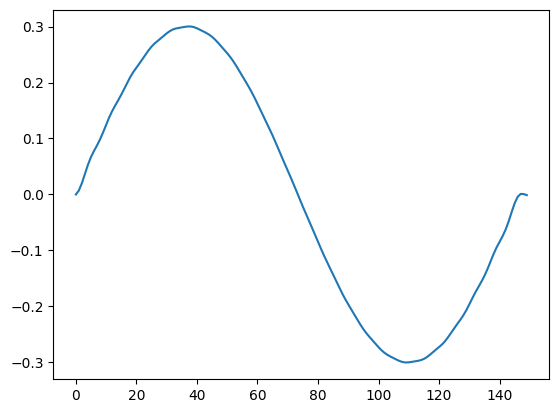

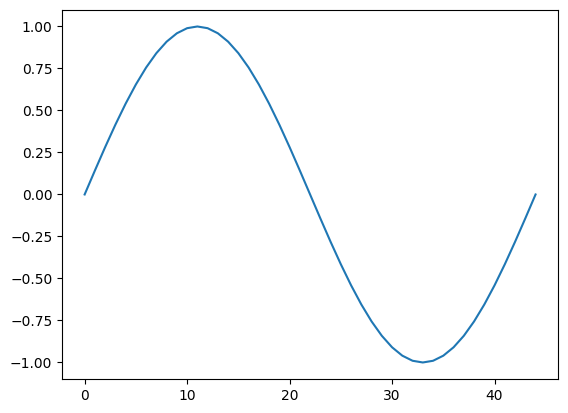

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def fft_zero_pad(signal, target_length):
    N = len(signal)
    # Compute the FFT
    spectrum = np.fft.fft(signal)
    
    # Create a new spectrum with the desired length
    if N % 2 == 0:
        # Even-length signal: split the spectrum in half
        half = N // 2
        new_spectrum = np.concatenate([
            spectrum[:half],
            np.zeros(target_length - N, dtype=complex),
            spectrum[half:]
        ])
    else:
        # Odd-length signal: adjust accordingly
        half = (N + 1) // 2
        new_spectrum = np.concatenate([
            spectrum[:half],
            np.zeros(target_length - N, dtype=complex),
            spectrum[half:]
        ])
    
    # Inverse FFT to get the time-domain signal
    extended_signal = np.fft.ifft(new_spectrum)
    return np.real(extended_signal)

# Example usage:
original_signal = np.sin(2 * np.pi * np.linspace(0, 1, 45))  # example periodic signal
extended_signal = fft_zero_pad(original_signal, 150)
plt.plot(extended_signal)
plt.figure()
plt.plot(original_signal)
plt.show()


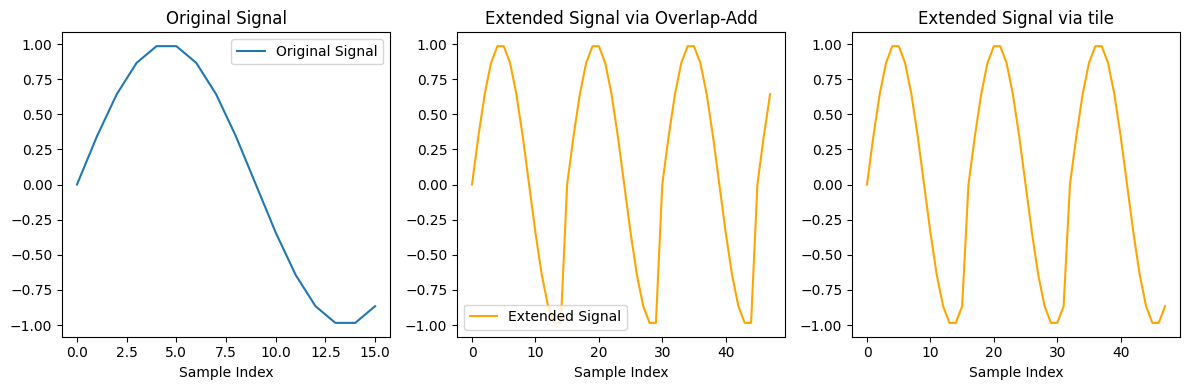

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def overlap_add_extend(signal, target_length, overlap_ratio=0.2):
    """
    Extends a periodic-like signal to a target length using the overlap-add method with windowing.
    
    Parameters:
      signal (1D array): Original signal to be extended.
      target_length (int): Desired length of the extended signal.
      overlap_ratio (float): Fraction of the signal length to overlap (default is 0.5).
      
    Returns:
      extended_signal (1D array): The extended signal of length target_length.
    """
    L = len(signal)
    
    # Determine the number of samples to overlap.
    overlap_length = int(np.floor(overlap_ratio * L))
    
    # Hop length: the step between successive signal copies.
    hop_length = L - overlap_length
    
    # Calculate how many segments are needed to cover the target length.
    n_segments = int(np.ceil((target_length - overlap_length) / hop_length))
    
    # Create a Hann window of the same length as the signal.
    window = np.hanning(L)
    
    # Initialize arrays to hold the extended signal and a weighting factor.
    extended_signal = np.zeros(target_length)
    weight = np.zeros(target_length)
    
    # Loop over each segment and add the windowed signal into the extended signal.
    for i in range(n_segments):
        start = i * hop_length
        end = start + L
        
        if end > target_length:
            # If the last segment exceeds the target length, trim the segment.
            effective_length = target_length - start
            seg = signal[:effective_length]
            win = window[:effective_length]
            extended_signal[start:target_length] += seg * win
            weight[start:target_length] += win
        else:
            extended_signal[start:end] += signal * window
            weight[start:end] += window

    # Normalize the overlapping regions by dividing by the summed window contributions.
    # (This avoids amplitude modulation where segments overlap.)
    nonzero = weight != 0
    extended_signal[nonzero] /= weight[nonzero]
    
    return extended_signal

# === Example Usage ===
# Create an example periodic signal (e.g., a 5 Hz sine wave sampled at 100 Hz over 1 second)
fs = 18
t = np.linspace(0, 1, fs, endpoint=False)
freq = 1  # Hz
signal = np.sin(2 * np.pi * freq * t)
signal = signal[:16]
# Set the desired extended length (e.g., three times the original length)
target_length = 3 * len(signal)

# Extend the signal using the overlap-add method
extended_signal = overlap_add_extend(signal, target_length, overlap_ratio=0.1)

dummy_signal = np.tile(signal, (3,1))
# Plot the original and extended signals for comparison.
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Sample Index')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(extended_signal, label='Extended Signal', color='orange')
plt.title('Extended Signal via Overlap-Add')
plt.xlabel('Sample Index')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(dummy_signal.flatten(), label='Extended Signal', color='orange')
plt.title('Extended Signal via tile')
plt.xlabel('Sample Index')

plt.tight_layout()
plt.show()